In [39]:
import numpy as np
import pandas as pd
import random
import gr4j as gr
import funcion_objetivo as fo
import matplotlib.pyplot as plt

In [10]:
# Datos de prueba para el sistema
df_prueba = pd.read_excel('datos_caudal_prueba.xlsx')

In [11]:
df_prueba
pptn = np.array(df_prueba['Precipitacion'])
q_obs = np.array(df_prueba['Caudal observado'])
etp = np.ones_like(pptn)*2.505
area = 27.33

In [49]:
def parametros():
    # Se aplican los intervalos sugeridos en (Perrin, 2003)
    X1 = random.uniform(100, 3000) #100 - 1200
    X2 = random.uniform(-5, 3) #-5 - 3
    X3 = random.uniform(20, 300) #20 - 300
    X4 = random.uniform(1.1, 2.9) #1.1-2.9

    return [X1,X2,X3,X4]

def poblacion_inicial(muestra:int):
    
    # genera una lista con la poblacion segun la muestra indicada
    poblacion = [parametros() for _ in range(muestra)]
    return poblacion

def datos_cuenca(
        area:float,etp:list,
        pptn:list,
        ):
    
    return area,etp,pptn

def fitness(
        poblacion:list, etp:list,
        pptn:list, q_obs:list,
        area: float
        ):
    # para la estimacion del fitness
    # Se aplica el Nash como calificacion

    # datos de la cuenca

    #Lista vacia que almacena las salidas de simulacion
    almac_fitness = []

    # ciclo for que itera sobre la poblacion
    for i in range(len(poblacion)):

        # Extrae los parametros que contiene cada miembro de
        # la poblacion
        params = poblacion[i]

        dic_params = {

        'X1':params[0],  # 100-1200
        'X2':params[1],  # -5 a 3
        'X3':params[2],  # 20-300
        'X4':params[3],  # 1.1-2.9

        }

        # se define el diccionario de condiciones iniciales
        cond_iniciales = {

        'production_store': 0.6,
        'routing_store': 0.68

        }

        q_simulado = np.array(gr.gr4j(
            pptn,
            etp,
            dic_params,
            cond_iniciales
        ))

        q_simulado_escalado = q_simulado*(area)/86.4

        # Se calcula el nash, el cual será el calificador de fitness
        nash = fo.nash(q_obs,q_simulado_escalado)
        # Se almacena cada salida de la poblacion con su respectivo fitness
        resultado_fitness = (params,nash)

        # almacenamiento de resultados
        # Solo se mantienen resultados con Nash positivo
        if nash > 0:
            almac_fitness.append(resultado_fitness)

    return almac_fitness

In [50]:
def run_gr4j(
        params: list,
        pptn:list,
        etp:list,
        ) -> list:
    
        dic_params = {

        'X1':params[0],  # 100-1200
        'X2':params[1],  # -5 a 3
        'X3':params[2],  # 20-300
        'X4':params[3],  # 1.1-2.9

        }

        # se define el diccionario de condiciones iniciales
        cond_iniciales = {

        'production_store': 0.6,
        'routing_store': 0.68

        }

        q_simulado = np.array(gr.gr4j(
            pptn,
            etp,
            dic_params,
            cond_iniciales
        ))

        q_simulado_escalado = q_simulado*(area)/86.4

        return q_simulado_escalado

In [51]:
# Se desarrolla la funcion de selección
# para seleccionar dos resultados de la aplicacion
# del fitness
poblacion = poblacion_inicial(1000)
resultados = fitness(
    poblacion,etp,
    pptn,q_obs, 27.33
)

def seleccion(resultados: list) -> list:
    # Aplica la funcion de seleccion del modula random
    # Devuelve los dos padres seleccionados (grupos de parametros)
    # 
    return random.choices(
        # Se ingresa la poblacion    
        population= [muestra[0] for muestra in resultados],
        # De los resultados se extrae el arreglo con los Nash
        # que funcionan como fitness en este caso
        weights=[fitness[1] for fitness in resultados],
        k=2
    )

In [52]:
# Creacion del cruce
def apareamiento(padre1: list, padre2: list) -> tuple: 
    # Se estima la longitud del array de parametros
    length = len(padre1)
    # Se genera un numero  aleatoria a partir del cual truncar
    # los arreglos y generar los cruces
    p = random.randint(1, length-1)
    # Se genera el cruce
    cruce1 = padre1[0:p] + padre2[p:]
    cruce2 = padre2[0:p] + padre1[p:]
    return cruce1, cruce2
# Mutacion

In [53]:
def mutacion(padre: list, num: int = 1, probabilidad:float = 0.5) -> list:
    for _ in range(num):
        # Esta linea genera un valor aleatorio de indice segun la longitud
        # del array suministrado
        indice = random.randrange(len(padre))
        # Corre la funcion de parametros para generar un nuevo set aleatorio
        # Con el indice logra extraer el que va a ser modificado
        parametros_mutacion = parametros()
        # Condicional para chequear si un numero aleatorio es mayor a la condicion de mutacion
        num_aleatorio = random.random()

        if num_aleatorio < probabilidad:
            padre[indice] = parametros_mutacion[indice]
        
    return padre


In [58]:
# Funcion que corre el loop principal

def main_loop(
        funcion_poblacion: poblacion_inicial,
        fitness_func: fitness,
        funcion_seleccion: seleccion,
        funcion_apareamiento: apareamiento,
        funcion_mutacion: mutacion,
        umbral_nash:float,
        pptn: list,
        area: float,
        q_obs: list,
        etp: list,
        limite_generacion: int = 100,
        ) -> tuple:
    
    poblacion = funcion_poblacion(100)

    

    for i in range(limite_generacion):
        
        resultados_fitness = fitness_func(
            poblacion,
            etp,
            pptn,
            q_obs,
            area
        )
        
        poblacion_fitness = [fitness[0] for fitness in resultados_fitness]
        nash = [fitness[1] for fitness in resultados_fitness]
        # print(poblacion_fitness)
        # print(nash)

        poblacion_sorted = sorted(
            resultados_fitness,
            key=lambda x: x[1],
            reverse=True
        )
        # Chequea si la primera combinacion de parametros 
        # Supera el umbral establecido
        if poblacion_sorted[0][1] >= umbral_nash:
            break

        # Proxima generacion 

        proxima_generacion = poblacion_fitness[0:2]

        # Ciclo para pasar a la siguiente generacion
        for j in range(int(len(poblacion)/2)-1):
            
            # Seleccion de padres de la siguiente generacion
            padres = seleccion(resultados_fitness)

            # Reproduccion entre los padres
            hijo_1, hijo_2 = apareamiento(padre1=padres[0], padre2=padres[1])
            # Aplicacion de la mutacion
            hijo1_mutado = mutacion(hijo_1,probabilidad=0.25)
            hijo2_mutado = mutacion(hijo_2,probabilidad=0.25)
            # Almacenamiento de la siguiente generacion
            proxima_generacion += [hijo1_mutado, hijo2_mutado]

        poblacion = proxima_generacion 

    resultados_poblacion_final = fitness_func(
            poblacion,
            etp,
            pptn,
            q_obs,
            area
        )


    resultados = sorted(
        resultados_poblacion_final,
        key=lambda x: x[1],
        reverse=True
    )

    print('Generacion:',i)
    return resultados


In [55]:
parametros = main_loop(
        poblacion_inicial,
        fitness,
        seleccion,
        apareamiento,
        mutacion,
        0.77,
        pptn,
        area,
        q_obs,
        etp,
        limite_generacion= 100,
        )

parametros_simulacion = parametros[0][0]
q_simulado = run_gr4j(
    parametros_simulacion,
    pptn,
    etp,
)

Generacion: 99


In [57]:
parametros

[([109.04660269949596,
   -1.678278608337063,
   170.0053760378823,
   1.12967876338101],
  0.74169),
 ([109.04660269949596,
   -2.1237325717012236,
   130.12278560534196,
   1.12967876338101],
  0.735),
 ([109.04660269949596,
   0.43579508040561876,
   212.0650954893372,
   1.12967876338101],
  0.71416),
 ([109.04660269949596,
   0.6882939508368606,
   170.0053760378823,
   1.1165568358912605],
  0.71197),
 ([109.04660269949596,
   -2.8990826479774006,
   153.87037172344125,
   1.1426044804292033],
  0.71123),
 ([109.04660269949596,
   -2.4491672680692496,
   212.0650954893372,
   1.12967876338101],
  0.70485),
 ([109.04660269949596,
   0.8166136566857674,
   191.00228229107194,
   1.12967876338101],
  0.70275),
 ([109.04660269949596,
   0.28424554062583773,
   265.6184286368201,
   1.1165568358912605],
  0.69535),
 ([109.04660269949596,
   -3.5021581608016623,
   170.0053760378823,
   1.1318320254446825],
  0.69338),
 ([109.04660269949596,
   -1.3938853348648594,
   170.0053760378823

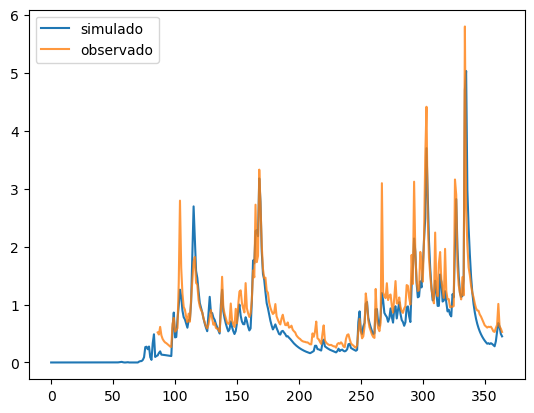

In [46]:
plt.plot(q_simulado,label='simulado')
plt.plot(q_obs,label='observado',alpha=0.8)
plt.legend()